In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
import os

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/face emotion recognition/face_data.csv")
display(df)

,emotion_label,Usage,pixels,emotion
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,anger
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...,anger
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...,fear
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,sadness
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,neutral
...,...,...,...,...
35335,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,neutral
35336,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...,happiness
35337,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,anger
35338,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,happiness


In [ ]:
df.emotion.value_counts()

happiness    8989
neutral      6198
sadness      6077
fear         5121
anger        4953
surprise     4002
Name: emotion, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


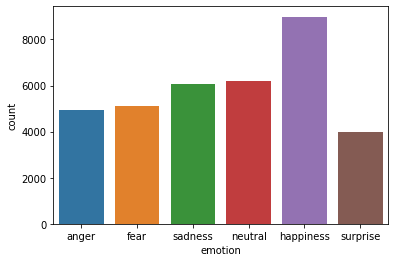

In [ ]:
sns.countplot(df.emotion)
plt.show()

In [ ]:
train_df = df[df.Usage=='Training']
validation_df = df[df.Usage=="PrivateTest"]
test_df = df[df.Usage=='PublicTest']

In [ ]:
test_df.to_csv("test_data.csv", index=False)

In [ ]:
X_train = train_df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_train = np.stack(X_train, axis=0)
print("X_train shape = ", X_train.shape)

X_validation = validation_df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_validation = np.stack(X_validation, axis=0)
print("X_validation shape = ", X_validation.shape)

X_test = test_df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_test = np.stack(X_test, axis=0)
print("X_test shape = ", X_test.shape)

X_train shape =  (28273, 48, 48, 1)
X_validation shape =  (3534, 48, 48, 1)
X_test shape =  (3533, 48, 48, 1)


In [ ]:
le = LabelEncoder()
Y_train = le.fit_transform(train_df.emotion_label)
Y_train = np_utils.to_categorical(Y_train)
print("Y_train shape = ", Y_train.shape)

Y_validation = le.fit_transform(validation_df.emotion_label)
Y_validation = np_utils.to_categorical(Y_validation)
print("Y_validation shape = ", Y_validation.shape)

Y_test = le.fit_transform(test_df.emotion_label)
Y_test = np_utils.to_categorical(Y_test)
print("Y_test shape = ", Y_test.shape)

Y_train shape =  (28273, 6)
Y_validation shape =  (3534, 6)
Y_test shape =  (3533, 6)


In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = Y_train.shape[1]

In [ ]:
# Normalizing results
X_train = X_train / 255
X_validation = X_validation / 255
X_test = X_test / 255

In [ ]:
def build_model(optimizer):
  model = Sequential(name='DCNN')
  model.add(Conv2D(64,(5,5), padding='same', activation='elu', input_shape=(img_width, img_height, img_depth), kernel_initializer='he_normal',))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(5,5), padding='same', activation='elu', kernel_initializer='he_normal', name='conv1'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(128,(3,3), padding='same', activation='elu', kernel_initializer='he_normal', name='conv2'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(3,3), padding='same', activation='elu', kernel_initializer='he_normal', name='conv3'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(3,3), padding='same', activation='elu', kernel_initializer='he_normal', name='conv4'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(128,(3,3), padding='same', activation='elu', kernel_initializer='he_normal', name='conv5'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(3,3), padding='same', activation='elu', kernel_initializer='he_normal', name='conv6'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(3,3), padding='same', activation='elu', kernel_initializer='he_normal', name='conv7'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(256,(3,3), padding='same', activation='elu', kernel_initializer='he_normal', name='conv8'))
  model.add(BatchNormalization())
  model.add(Conv2D(256,(3,3), padding='same', activation='elu', kernel_initializer='he_normal', name='conv9'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(128, activation='elu', kernel_initializer='he_normal',))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  model.add(Dense(6, activation='softmax'))

  model.compile(loss="categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])
  model.summary()

  return model

In [ ]:
# "early stopping" for avoiding overfitting training data
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)
# "ReduceLROnPlateau" for learning rate
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
# configure the model
optimizer = Adam(lr=0.001)
model = build_model(optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                              

In [ ]:
history = model.fit_generator(
    train_datagen.flow(X_train, Y_train, batch_size=32),
    validation_data = (X_validation, Y_validation),
    epochs=100,
    callbacks=callbacks,
    use_multiprocessing=True 
    )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


884/884 [==============================] - 29s 28ms/step - loss: 2.0630 - accuracy: 0.2288 - val_loss: 1.6444 - val_accuracy: 0.3311 - lr: 0.0010
Epoch 2/100
884/884 [==============================] - 24s 27ms/step - loss: 1.6124 - accuracy: 0.3474 - val_loss: 1.4308 - val_accuracy: 0.4516 - lr: 0.0010
Epoch 3/100
884/884 [==============================] - 24s 27ms/step - loss: 1.4600 - accuracy: 0.4169 - val_loss: 1.2809 - val_accuracy: 0.4952 - lr: 0.0010
Epoch 4/100
884/884 [==============================] - 24s 27ms/step - loss: 1.3521 - accuracy: 0.4685 - val_loss: 1.2749 - val_accuracy: 0.4904 - lr: 0.0010
Epoch 5/100
884/884 [==============================] - 23s 26ms/step - loss: 1.2814 - accuracy: 0.5011 - val_loss: 1.1862 - val_accuracy: 0.5334 - lr: 0.0010
Epoch 6/100
884/884 [==============================] - 24s 27ms/step - loss: 1.2380 - accuracy: 0.5163 - val_loss: 1.0926 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 7/100
884/884 [==============================] - 24s 27ms/

<Figure size 432x288 with 0 Axes>

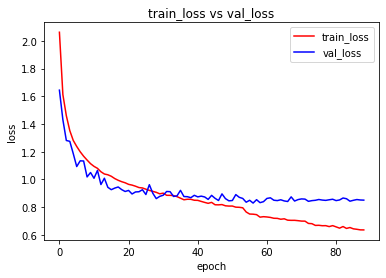

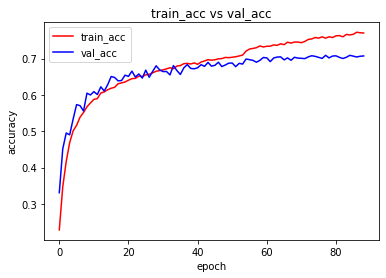

<Figure size 432x288 with 0 Axes>

In [ ]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [ ]:
loss = model.evaluate(X_test, Y_test) 
print("Test Loss " + str(round(loss[0],4)))
print("Test Acc: " + str(round(loss[1],4)))

111/111 [==============================] - 1s 11ms/step - loss: 0.9055 - accuracy: 0.6943
Test Loss 0.9055
Test Acc: 0.6943


In [ ]:
y_pred_ = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
y_test = np.argmax(Y_test, axis=1)

111/111 [==============================] - 1s 8ms/step


In [ ]:
target_names = ['anger', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
print(classification_report(y_pred, y_test, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.72      0.58      0.64       576
        fear       0.45      0.64      0.53       350
   happiness       0.86      0.89      0.88       864
     sadness       0.57      0.62      0.59       608
    surprise       0.81      0.79      0.80       425
     neutral       0.68      0.58      0.62       710

    accuracy                           0.69      3533
   macro avg       0.68      0.68      0.68      3533
weighted avg       0.71      0.69      0.70      3533



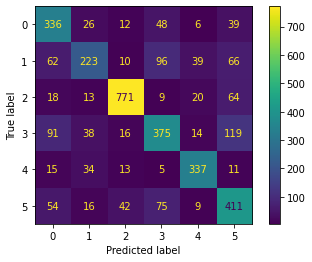

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
y_pred_proba = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
print(y_pred_proba)
print(y_pred)

111/111 [==============================] - 1s 8ms/step
[[8.2542861e-01 2.3491740e-02 3.7990469e-02 5.4239947e-02 6.7119859e-04
  5.8178011e-02]
 [7.6443374e-01 2.5851425e-02 1.5842207e-03 1.7433929e-01 1.9032216e-03
  3.1888098e-02]
 [2.0966882e-02 8.6415105e-02 5.4298941e-02 7.7409841e-02 1.4908977e-03
  7.5941837e-01]
 ...
 [2.6464466e-02 2.9606132e-02 1.5953317e-02 5.1414150e-01 1.3717061e-03
  4.1246298e-01]
 [2.1251453e-01 1.3781914e-01 3.0668229e-03 4.3342575e-01 8.6648474e-03
  2.0450881e-01]
 [2.7262011e-01 9.3925603e-02 4.7360649e-03 3.3733186e-01 4.2434423e-03
  2.8714296e-01]]
[0 0 5 ... 3 3 3]


In [ ]:
y_pred_df = pd.DataFrame(y_pred_proba)
y_pred_df.columns = ["anger", "fear", "happiness", "sadness", "surprise", "neutral"]
y_pred_df['pred_label'] = y_pred

In [ ]:
y_pred_df.pred_label[y_pred_df.pred_label==0] = 'anger'
y_pred_df.pred_label[y_pred_df.pred_label==1] = 'fear'
y_pred_df.pred_label[y_pred_df.pred_label==2] = 'happiness'
y_pred_df.pred_label[y_pred_df.pred_label==3] = 'sadness'
y_pred_df.pred_label[y_pred_df.pred_label==4] = 'surprise'
y_pred_df.pred_label[y_pred_df.pred_label==5] = 'neutral'
display(y_pred_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

,anger,fear,happiness,sadness,surprise,neutral,pred_label
0,0.825429,0.023492,0.037990,0.054240,0.000671,0.058178,anger
1,0.764434,0.025851,0.001584,0.174339,0.001903,0.031888,anger
2,0.020967,0.086415,0.054299,0.077410,0.001491,0.759418,neutral
3,0.000063,0.000337,0.997493,0.000037,0.002006,0.000064,happiness
4,0.001850,0.000423,0.890872,0.001774,0.000918,0.104163,happiness
...,...,...,...,...,...,...,...
3528,0.014167,0.018716,0.001254,0.937605,0.000050,0.028207,sadness
3529,0.000043,0.000035,0.999736,0.000009,0.000117,0.000060,happiness
3530,0.026464,0.029606,0.015953,0.514141,0.001372,0.412463,sadness
3531,0.212515,0.137819,0.003067,0.433426,0.008665,0.204509,sadness


In [ ]:
test_df.reset_index(inplace=True)
display(test_df.head())

,index,emotion_label,Usage,pixels,emotion
0,28273,0,PublicTest,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,anger
1,28274,4,PublicTest,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,sadness
2,28275,6,PublicTest,205 203 236 157 83 158 120 116 94 86 155 180 2...,neutral
3,28276,3,PublicTest,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,happiness
4,28277,3,PublicTest,235 233 223 109 34 37 34 31 28 38 56 69 106 13...,happiness


In [ ]:
test_df = test_df.drop(['index'],axis=1)
test_pred = pd.concat([test_df, y_pred_df], axis=1)
test_pred = test_pred.drop(['emotion_label', 'Usage', 'pixels'], axis=1)
display(test_pred)

,emotion,anger,fear,happiness,sadness,surprise,neutral,pred_label
0,anger,0.825429,0.023492,0.037990,0.054240,0.000671,0.058178,anger
1,sadness,0.764434,0.025851,0.001584,0.174339,0.001903,0.031888,anger
2,neutral,0.020967,0.086415,0.054299,0.077410,0.001491,0.759418,neutral
3,happiness,0.000063,0.000337,0.997493,0.000037,0.002006,0.000064,happiness
4,happiness,0.001850,0.000423,0.890872,0.001774,0.000918,0.104163,happiness
...,...,...,...,...,...,...,...,...
3528,sadness,0.014167,0.018716,0.001254,0.937605,0.000050,0.028207,sadness
3529,happiness,0.000043,0.000035,0.999736,0.000009,0.000117,0.000060,happiness
3530,sadness,0.026464,0.029606,0.015953,0.514141,0.001372,0.412463,sadness
3531,sadness,0.212515,0.137819,0.003067,0.433426,0.008665,0.204509,sadness


In [ ]:
test_pred.to_csv("test_pred_proba.csv", index=False)
from google.colab import files
files.download('test_pred_proba.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

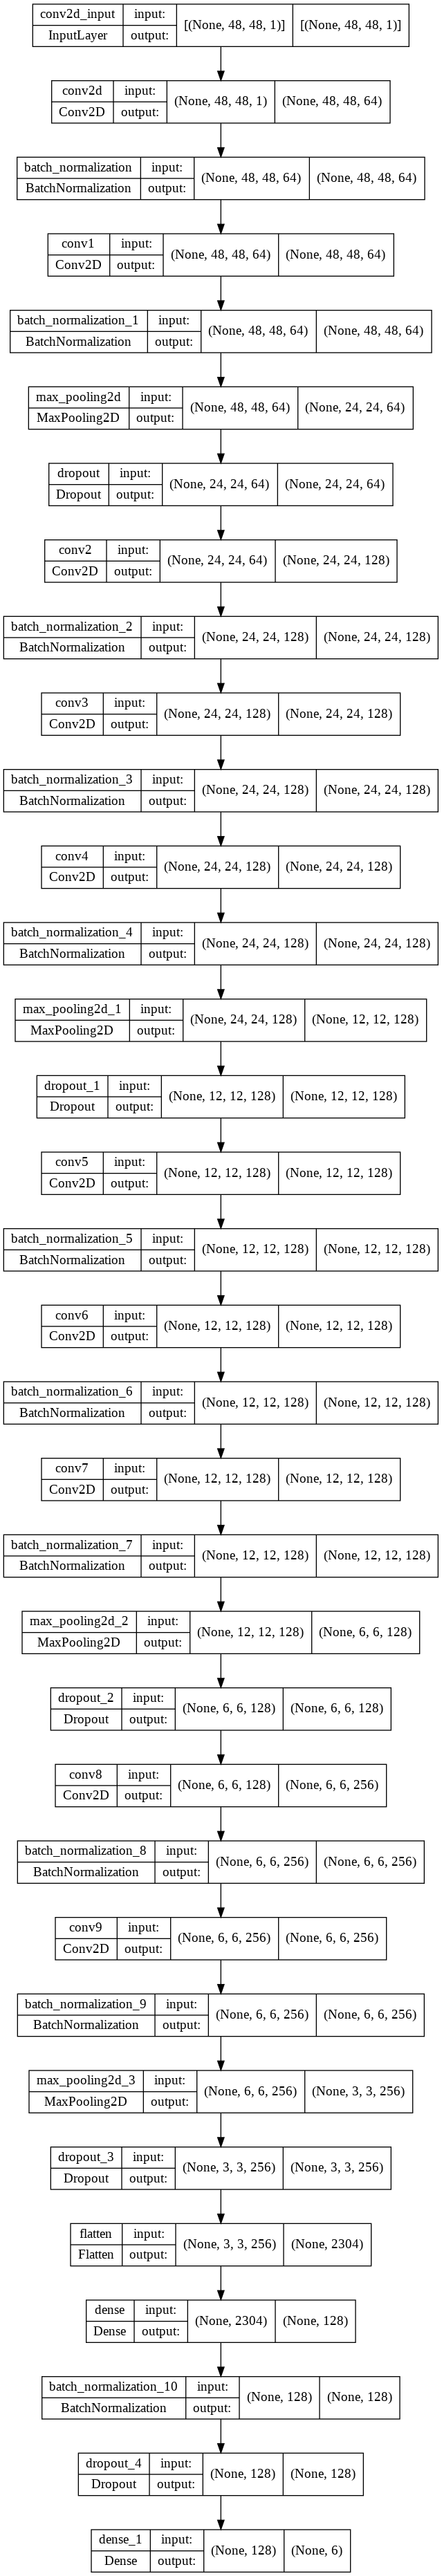

In [ ]:
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)